# Window Functions

LSST assigns galaxies to one of 30 redshift bins ranging from $z = 0.15$ to $z = 3.5$ with a bin width of $\sigma_z = \sigma_{z0}(1+z)$. I find that a value of $\sigma_{z0} = 0.04817$ is required, instead of their quoted value of 0.05. Window functions are defined by

\begin{equation*}
W_i(z) = b(z) n_i(z)/\bar{n}_i(z)
\end{equation*}

where $b(z) = 1+0.84z$ is the galaxy bias,

\begin{equation*}
n_i(z) = \frac{1}{2}n(z)[{\rm erf}(x_{i+1})-{\rm erf}(x_i)] \qquad x_i = \frac{z_{ph}^{(i)}-z}{\sqrt{2}\sigma_z} \qquad \sigma_z = \sigma_{z0}(1+z) \qquad n(z) = 1126.6 z^2 e^{-2z}
\end{equation*}

is the binned galaxy number density normalized to 50 galaxies per square arcmin by the prefactor of 1126.6 on $n(z)$, and

\begin{equation*}
\bar{n}_i(z) = \int_0^\infty n_i(z)dz
\end{equation*}

where numerically we integrate out to $z = 5$ instead of $z = \infty$.

bounds of z-bins [0.15, 0.45, 0.93, 1.56, 2.39, 3.5]
average z of z-bins [0.3, 0.69, 1.25, 1.98, 2.94]


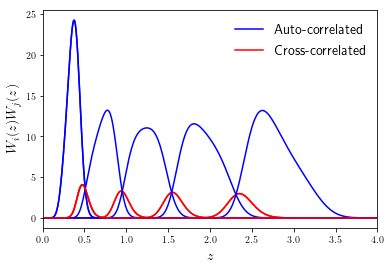

In [1]:
import numpy as np
import scipy as sp
from scipy import special
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex = True)

def bins(zmin = 0.15, zmax = 3.5, sigmaz0 = 0.04817):
    z = zmin
    zlist = [z]
    while z < zmax:
        z += sigmaz0*(1+z)
        zlist.append(np.round(z,2))
    zbounds = [zlist[0],zlist[5],zlist[11],zlist[17],zlist[23],zlist[29]]
    zavg = [np.round((zbounds[i]+zbounds[i+1])/2,2) for i in range(len(zbounds)-1)]
    return zbounds,zavg

zbounds = bins()[0]
print('bounds of z-bins',zbounds)
zavg = bins()[1]
print('average z of z-bins',zavg)

def n(z, alpha = 2, zstar = 0.5 , beta = 1, norm = 1126.6):
    return norm*np.power(z,alpha)*np.exp(-np.power(z/zstar,beta))

def I(a,b,z):
    return 0.5*(sp.special.erf(14.1421*(z-a)/(1+z))-sp.special.erf(14.1421*(z-b)/(1+z)))

zlist = np.arange(0.,5.,0.01)
bias = np.reshape(np.asarray(1+0.84*zlist),(1,len(zlist)))
ni = [[n(z)*I(zbounds[i],zbounds[i+1],z)/I(0,5,z) for z in zlist] for i in range(len(zbounds)-1)]
nibar = [np.trapz(ni[i],zlist,dx = 0.01) for i in range(len(ni))]
window = bias*np.asarray(ni)/np.reshape(np.asarray(nibar),(len(nibar),1))

for i in range(len(window)):
    for j in range(len(window)):
        if i==j:
            plt.plot(zlist,window[i]*window[j],color = 'b')
        else:
            plt.plot(zlist,window[i]*window[j],color = 'r')
plt.plot(zlist,window[0]*window[0],color = 'b',label = r'Auto-correlated')
plt.plot(zlist,window[0]*window[1],color = 'r',label = r'Cross-correlated')
plt.legend(frameon = False,fontsize = 14)
plt.xlabel(r'$z$',size = 14)
plt.ylabel(r'$W_i(z)W_j(z)$',size = 14)
plt.xlim(0,4)
# plt.savefig('windows.pdf')

# interpolate to match redshifts of axionCAMB and then export
zmin_camb = 0
zmax_camb = 4.5
numz_camb = 301
zlist_camb = np.linspace(zmin_camb,zmax_camb,numz_camb)
w_interp = [np.interp(zlist_camb,zlist,window[i]) for i in range(len(window))]
correlated_windows = [[w_interp[i]*w_interp[j] for i in range(len(w_interp))] for j in range(len(w_interp))]
# np.save('window_functions.npy',correlated_windows)

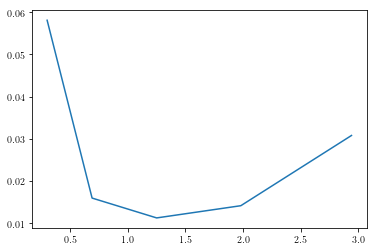

In [11]:
noise = [1/nibari for nibari in nibar]
plt.plot(zavg,noise)
plt.show()
plt.close('all')

